filtering.ipynb

Author: Anderson Steckler

This imports the data calculated from "tbinding_ldos.ipynb" and filters around the backscattering points

In [129]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import skimage

import pybinding as pb
from pybinding.repository import graphene

import os

from tqdm import tqdm

### Importing Data

In [130]:
%matplotlib inline

In [131]:
!mkdir freqout

mkdir: cannot create directory ‘freqout’: File exists


In [132]:
fpath = r"Calculations/graphene_delta_0d2_AP100_sbA/continous_ldos.csv"
df=pd.read_csv(fpath)
df.head()

,Unnamed: 0,x,y,Re(z),Im(z),MeshSize,DiscreteSize,LDOS Energy
0,0,-20.00000,-20.0,0.003605,0.0,1000,20,0.2
1,1,-19.95996,-20.0,0.004877,0.0,1000,20,0.2
2,2,-19.91992,-20.0,0.005860,0.0,1000,20,0.2
3,3,-19.87988,-20.0,0.006377,0.0,1000,20,0.2
4,4,-19.83984,-20.0,0.006446,0.0,1000,20,0.2


In [133]:
# Get the sample name to use on graphs from directory
dir_path = os.path.dirname(fpath)
sample_name = os.path.basename(dir_path)
print(sample_name)

graphene_delta_0d2_AP100_sbA


In [134]:
w = int(np.sqrt(np.size(df['x'])))

x = np.reshape(df['x'], (w, w))
y = np.reshape(df['y'], (w, w))
z = np.reshape(df['Re(z)'] + 1j * df['Im(z)'], (w, w)).astype(np.complex128)

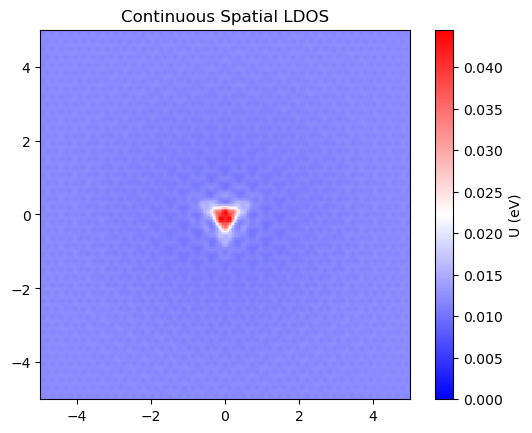

In [135]:
fig3, ax3 = plt.subplots()

z_min, z_max = 0, np.abs(z).max()

c = ax3.pcolormesh(x, y, np.abs(z), cmap='bwr', vmin=z_min, vmax=z_max)
ax3.axis([x.min(), x.max(), y.min(), y.max()])
fig3.colorbar(c, ax=ax3, label="U (eV)")
ax3.set_aspect("equal")
ax3.set_xlim(-5, 5)
ax3.set_ylim(-5, 5)

ax3.set_title("Continuous Spatial LDOS")
fig3.savefig("output/continuous_ldos.png")

### FFT and Filtering

Text(0.5, 1.0, '2D FFT: graphene_delta_0d2_AP100_sbA')

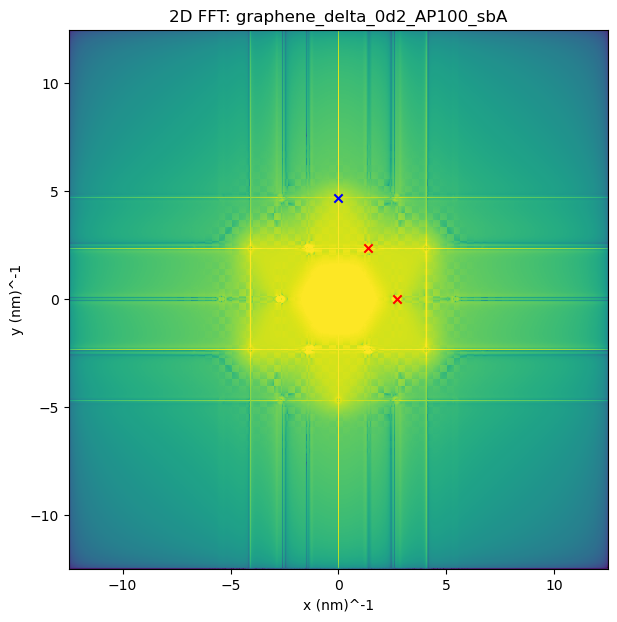

In [136]:
# FFT
ftz = np.fft.fft2(z)
ftz = np.fft.fftshift(ftz) # Shifts zero component freq to center

# Log scale
plz = np.log(np.abs(ftz ** 2))

# Generate Frequency Axis
# From tbinding_ldos
# x, y where generated from x = np.linspace(-size, size, mesh_size)
# In this example x = np.linspace(-20, 20, 1000)

l = np.linspace(-20, 20, 1000)

stepl = l[1] - l[0]
fx = np.fft.fftfreq(len(l), stepl)
fy = np.fft.fftfreq(len(l), stepl)
fxs = np.fft.fftshift(fx)
fys = np.fft.fftshift(fy)

# Plotting analytic K valleys ontop
#kx = [ 8.51553203,-8.51553203,0]
#ky = [ 4.91644471, 4.91644471, -9.83288942]
#kpx = [ 8.51553203,-8.51553203,0]
#kpy = [-4.91644471,-4.91644471,9.83288942]

# From Bena 2008
acc=0.142 #nm
Kx = 1 * np.array([4*np.pi/(3*np.sqrt(3)), -4*np.pi/(3*np.sqrt(3)), 2 * np.pi/(3 * np.sqrt(3)), -2 * np.pi/(3 * np.sqrt(3)), 2 * np.pi/(3 * np.sqrt(3)), -2 * np.pi/(3 * np.sqrt(3))])
Ky = 1 * np.array([0, 0, 2*np.pi/3, 2*np.pi/3, -2*np.pi/3, -2*np.pi/3])


#difference
dpx = Kx[2] - Kx[0]
dpy = Ky[2] - Ky[0]

fig4, ax4 = plt.subplots(figsize=(7, 7))
ax4.pcolormesh(fxs, fys, plz, vmax=np.mean(plz)/100)

#ax4.scatter(Kx, Ky, marker="x")
#ax4.scatter(dpx, dpy, marker='o', color='red')

a=0.24595
frac = (2 * np.pi)/(3 * a)
bx = np.sqrt(frac ** 2 + 3 * (frac) ** 2)
av = np.sqrt((3*a/2) ** 2 + (np.sqrt(3) * a/2) ** 2)

# From liu
deltaKx = 4 * np.pi / (3 * np.sqrt(3) * acc) * (1/(2 * np.pi))

# Rotate by 60 to get other point
# This comes from rotation matrix
dKR_x = 0.5 * deltaKx
dKR_y = np.sqrt(3)/2 * deltaKx

# Plotting delta K Point
ax4.scatter(deltaKx, 0, marker='x', color='red')

ax4.scatter(0, np.sqrt(3) * (bx) * (1/(2 * np.pi)), marker='x', color='blue')
ax4.scatter(dKR_x, dKR_y, marker='x', color='red')

ax4.set_xlabel("x (nm)^-1")
ax4.set_ylabel("y (nm)^-1")
ax4.set_aspect("equal")

ax4.set_title("2D FFT: " + sample_name)

#ax4.set_xlim(-5, 5)
#ax4.set_ylim(-5, 5)

#fig4.savefig("freqout/fft.png")

Text(0.5, 1.0, 'Filter Mask FFT: graphene_delta_0d2_AP100_sbA')

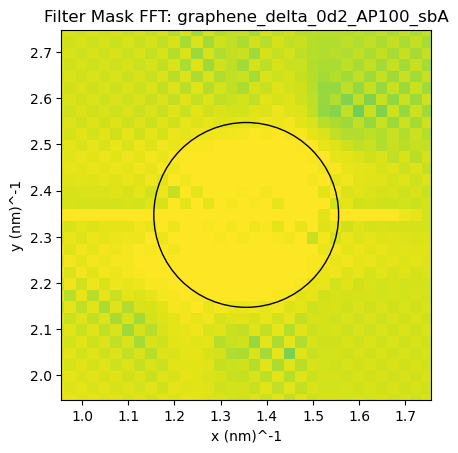

In [137]:
fig5, ax5 = plt.subplots()

ax5.pcolormesh(fxs, fys, plz, vmax=np.mean(plz)/100)

ax5.set_xlabel("x (nm)^-1")
ax5.set_ylabel("y (nm)^-1")
ax5.set_aspect("equal")


cradius = 0.2
circle = plt.Circle((dKR_x, dKR_y), cradius, fill=False)

ax5.set_xlim(dKR_x - 2 * cradius, dKR_x + 2 * cradius)
ax5.set_ylim(dKR_y - 2 * cradius, dKR_y + 2 * cradius)


ax5.set_aspect('equal')

ax5.add_patch(circle)

ax5.set_title("Filter Mask FFT: " + sample_name)

#fig5.savefig("freqout/zoom_filter.png")

In [138]:
# Convert to index value
x1, y1, r1 = 1.36, 2.35, 0.25
x2, y2, r2 = -1.36, -2.35, 0.25

#x1, y1, r1 = 2.7, 0, 0.4
#x2, y2, r2 = -2.7, 0, 0.4

ffx, ffy = np.meshgrid(fxs, fys)

dist = np.sqrt((ffx - x1) ** 2 + (ffy - y1) ** 2)
mask = dist >= r1

dist2 =  np.sqrt((ffx - x2) ** 2 + (ffy - y2) ** 2)
mask2 = dist2 >= r1

plzf = np.where(mask, 0, plz) + np.where(mask2, 0, plz)
ftzf = np.where(mask, 0, ftz) + np.where(mask2, 0, ftz)

(-3.0, 3.0)

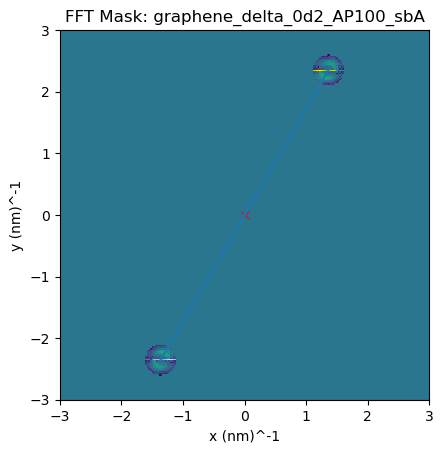

In [139]:
fig6, ax6 = plt.subplots()

ax6.set_xlabel("x (nm)^-1")
ax6.set_ylabel("y (nm)^-1")
ax6.set_aspect("equal")

ax6.pcolormesh(ffx, ffy, plzf)
ax6.set_aspect("equal")

ax6.scatter(0, 0, marker="x", color='red', alpha=0.5)
ax6.plot([x1, x2],[y1, y2])

ax6.set_title("FFT Mask: " + sample_name)

ax6.set_xlim(-3, 3)
ax6.set_ylim(-3, 3)

#fig6.savefig("freqout/mask.png")

In [140]:
#%matplotlib qt

In [141]:
np.shape(zn)

(250, 250)

In [142]:
np.max(Zr)

0.3507531701424058

In [143]:
np.shape(zsub)

(250, 250)

In [144]:
(2 * np.pi) / mDK

0.3689268220121708

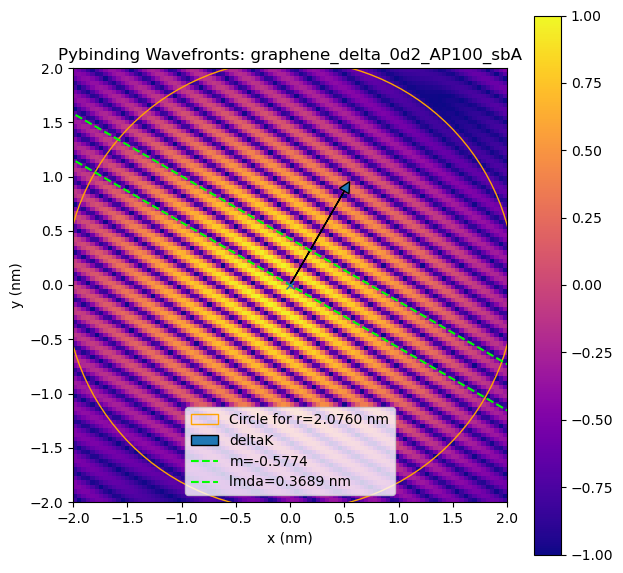

In [154]:
z_filtered = np.fft.ifft2(ftzf)

fig7, ax7 = plt.subplots(figsize=(7,7))

#zlog = np.log(np.abs(z_filtered))
zabs = np.abs(z_filtered)

# Code to multiply by rsquared
# Currently interested in the near behavior
# CGPT: get subset between x,y \in [-5, 5]
ws = 5
mask3 = (x >= -ws) & (x <= ws) & (y >= -ws) & (y <= ws)
zw = int(np.sqrt(len(zabs[mask3])))
zsub = zabs[mask3].reshape(zw, zw) #reshape since mask flattens
xsub = x[mask3].reshape(zw, zw)
ysub = y[mask3].reshape(zw, zw)

# Multiply by R2
#RR = xsub ** 2 + ysub ** 2
#zr = zsub * RR

# normalize linear scale
# Normalized to from between -1 and 1
minval, maxval = np.min(zsub), np.max(zsub)

zn = (zsub - minval)/(maxval-minval) # Normalize
zn = 2 * zn - 1 # Normalize to -1 1

c = ax7.pcolormesh(xsub,ysub,zn,cmap='plasma')

fig7.colorbar(c, ax=ax7)

#circ = plt.Circle((0, 0), 3.49353451, fill=False)
#ax7.add_patch(circ)

ax7.set_aspect('equal')
#ax7.set_xlim(-5, 5)
#ax7.set_ylim(-5, 5)
ax7.set_xlabel("x (nm)")
ax7.set_ylabel("y (nm)")

ax7.set_title("Pybinding Wavefronts: " + sample_name)


# Plotting Circle
cr = 2.0760#nm
circle = plt.Circle((0, 0), cr, fill=False, color='orange')
ax7.add_patch(circle)

# Plotting DK
mDK = np.sqrt(dKR_x ** 2 + dKR_y ** 2)
ax7.arrow(0, 0, dKR_x/mDK, dKR_y/mDK, head_width=0.1, head_length=0.1)
mDK = mDK * 2 * np.pi # still need to convert

# Plotting perpendicular to DK
m1, b1 = -dKR_x/dKR_y, 0
xlinf = np.linspace(-5, 5, 100)
ax7.plot(xlinf, m1 * xlinf + b1, 'lime', linestyle='dashed')

# Plotting wavelength
wavel = 2 * np.pi / mDK
# After some geometry
b2 = (m1 ** 2 + 1)/np.sqrt(m1 ** 2 + 1) * wavel
ax7.plot(xlinf, m1 * xlinf + b2, 'lime', linestyle='dashed')

ax7.legend([f"Circle for r={cr:.4f} nm", "deltaK", f"m={m1:.4f}", f"lmda={wavel:.4f} nm"])

ax7.plot(0, 0, marker="x")

ax7.set_xlim(-2, 2)
ax7.set_ylim(-2, 2)

plt.show()

#fig7.savefig("freqout/wavefronts.png")

### Trying to fit lines

Text(0.5, 1.0, 'Wavefronts: graphene_delta_0d2_AP100_sbA')

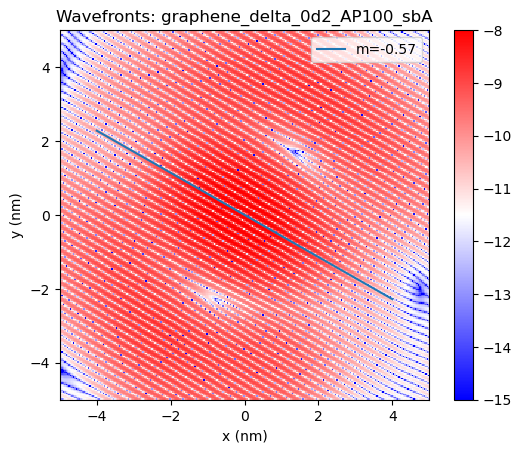

In [146]:
fig8, ax8 = plt.subplots()

c = ax8.pcolormesh(x,y,zlog,vmin=-15, vmax=-8, cmap='bwr')

fig8.colorbar(c, ax=ax8)

ax8.set_aspect('equal')
ax8.set_xlim(-5, 5)
ax8.set_ylim(-5, 5)
ax8.set_xlabel("x (nm)")
ax8.set_ylabel("y (nm)")

m1, b1 = -0.57, 0
xlin = np.linspace(-4, 4)
ax8.plot(xlin, m1 * xlin + b1)
ax8.legend([f'm={m1:.2f}'])

ax8.set_title("Wavefronts: " + sample_name)